In [163]:

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#modelos de clasificación
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set()
import time

### LECTURA DE LOS DATOS

In [164]:
df = pd.read_csv("calidad-vino-tinto-procesado.csv", sep=';')
print("FILAS,COLUMNAS: " + str(df.shape))
df.head()

FILAS,COLUMNAS: (1593, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [165]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000,1593.000000
mean,8.319523,0.527476,0.271161,2.538010,0.087501,15.875706,46.391714,2.213269,3.311224,0.658054,10.422379,5.634024
std,1.738144,0.179059,0.194954,1.409835,0.047140,10.466847,32.885012,9.681967,0.154190,0.169692,1.063917,0.808107
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997840,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,100.369000,4.010000,2.000000,14.900000,8.000000


### DISTRIBUCIÓN DE LA VARIABLE CALIDAD

5    681
6    633
7    198
4     53
8     18
3     10
Name: quality, dtype: int64

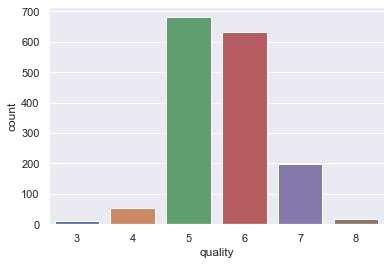

In [166]:
# Histograma de la variable 'calidad'
sns.countplot(data=df, x='quality')
df['quality'].value_counts()

### MATRIZ DE CORRELACIÓN

volatile acidity    0.392391
alcohol             0.475875
quality             1.000000
Name: quality, dtype: float64

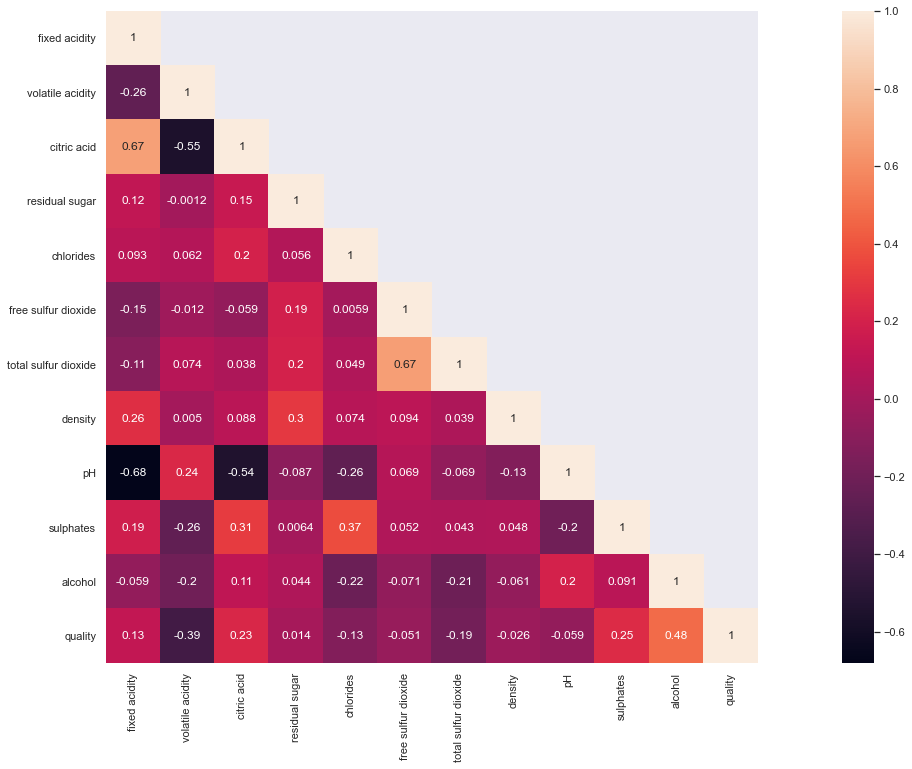

In [167]:

# genera la matriz de correlaciones entre atributos
cor_mat = df[:].corr()

mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

corr_y = abs(cor_mat["quality"])
highest_corr = corr_y[corr_y > 0.3]
highest_corr.sort_values(ascending=True)


### TRANSFORMACIÓN BINARIA DE LA VARIABLE DE SALIDA (CALIDAD)

0    1377
1     216
Name: goodquality, dtype: int64

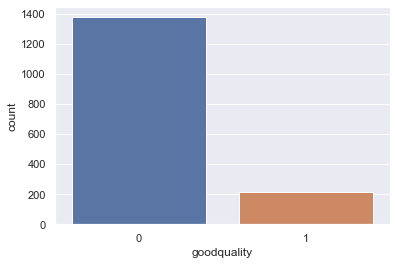

In [168]:
# Cambio los valores de clasificación por 1 y 0 (buna y mala calidad respectivamente)
df['goodquality'] = [1 if x >= 7 else 0 for x in df['quality']]
# separo el dataset y las etiquetas
X = df.drop(['quality','goodquality'], axis = 1)
y = df['goodquality']

sns.countplot(data=df, x='goodquality')
df['goodquality'].value_counts()


### VISUALIZACIÓN DE LOS DATOS

In [169]:
# mostrar el dataset reducido mediante TSNE o PCA
def mostrar_dataset_reducido_por(method,x, y):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    reduccion = 0
    title = 'REDUCCIÓN POR TSNE'
    if method == 'tsne':
        reduccion = TSNE(n_components=2, init='pca')
    elif method == 'pca':
        reduccion=PCA(n_components=2)
        title = 'REDUCCIÓN POR PCA'
    ax.set_title(title)
    x_new = reduccion.fit_transform(X)
    tmp_df = pd.DataFrame(np.column_stack([x_new, y]))
    tmp_df.columns = ["x1", "x2", "Y"]
    sns.scatterplot(x="x1", y="x2", hue="Y", data=tmp_df, ax=ax)   


    

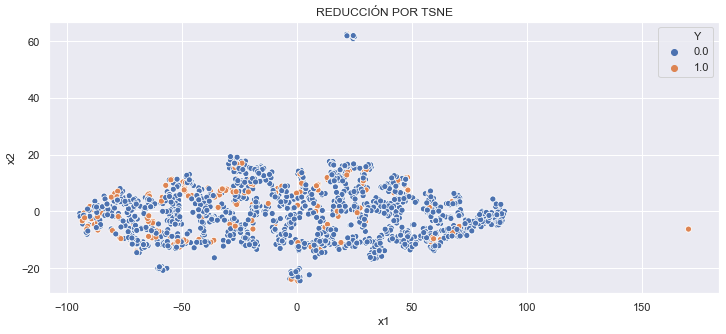

In [170]:
mostrar_dataset_reducido_por('tsne', X, y)

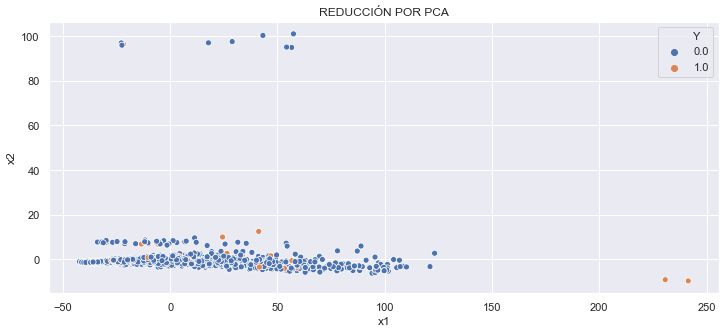

In [171]:
mostrar_dataset_reducido_por('pca', X, y)

### Estandarización de variables de características

In [172]:
# Normaliza las variables caracteristicas
X_features = X
X = StandardScaler().fit_transform(X)

In [ ]:
mostrar_dataset_reducido_por('tsne', X, y)


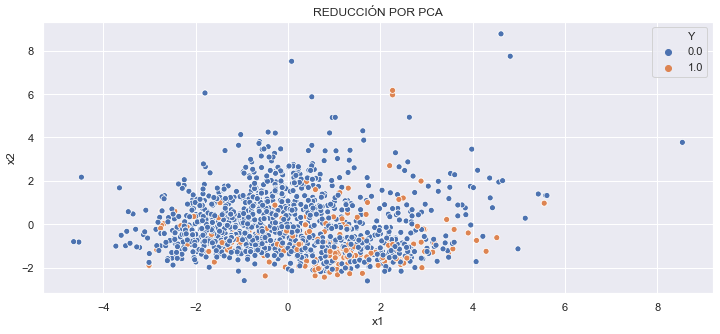

In [151]:
mostrar_dataset_reducido_por('pca', X, y)

### División del dataset en datos de entrenamiento y prueba

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# MODELADO

In [153]:
# ArboDecisión
model1 = DecisionTreeClassifier(random_state=1)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       350
           1       0.56      0.67      0.61        49

    accuracy                           0.89       399
   macro avg       0.76      0.80      0.78       399
weighted avg       0.90      0.89      0.90       399



In [156]:
#RandmForest
model2 = RandomForestClassifier(random_state=1)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       350
           1       0.76      0.59      0.67        49

    accuracy                           0.93       399
   macro avg       0.85      0.78      0.81       399
weighted avg       0.92      0.93      0.92       399



In [157]:
#AdaBoost
model3 = AdaBoostClassifier(random_state=1)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       350
           1       0.48      0.43      0.45        49

    accuracy                           0.87       399
   macro avg       0.70      0.68      0.69       399
weighted avg       0.87      0.87      0.87       399



In [158]:
#GradientBoosting
model4 = GradientBoostingClassifier(random_state=1)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       350
           1       0.62      0.61      0.62        49

    accuracy                           0.91       399
   macro avg       0.79      0.78      0.78       399
weighted avg       0.91      0.91      0.91       399



In [159]:
#XGBoost
model5 = xgb.XGBClassifier(random_state=1)
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       350
           1       0.64      0.69      0.67        49

    accuracy                           0.91       399
   macro avg       0.80      0.82      0.81       399
weighted avg       0.92      0.91      0.92       399



In [160]:
#SVM
model6 = SVC(C=50, gamma=0.01)
model6.fit(X_train, y_train)
y_pred6 = model6.predict(X_test)
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       350
           1       0.64      0.33      0.43        49

    accuracy                           0.89       399
   macro avg       0.78      0.65      0.69       399
weighted avg       0.88      0.89      0.88       399



# IMPORTANCIA DE LAS CARACTERÍSTICAS 

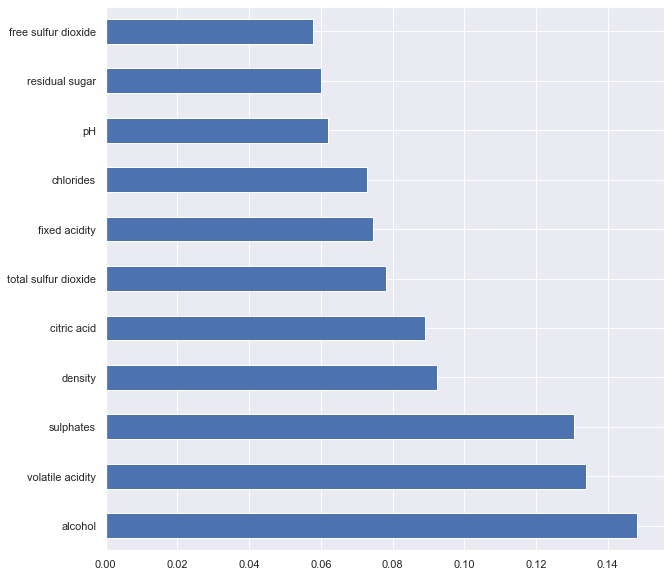

In [161]:
feat_importances = pd.Series(model2.feature_importances_, index=X_features.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

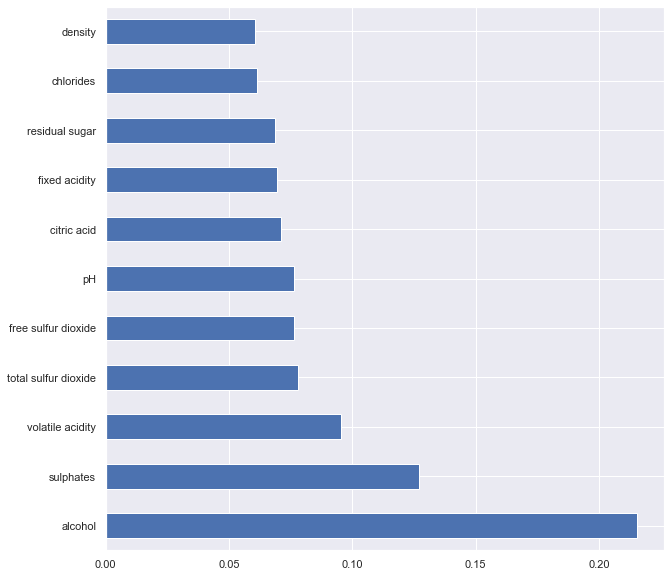

In [162]:
feat_importances = pd.Series (model5.feature_importances_, index = X_features.columns) 
feat_importances.nlargest (25) .plot (kind = 'barh', figsize = (10,10))

# Comparación de las 4 características principales

In [131]:
# Filtrado de datos solo de buena calidad
df_temp = df[df['goodquality']==1]
df_temp.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,goodquality
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.0
mean,8.863426,0.405231,0.377731,2.711111,0.076042,13.972222,34.638889,2.204837,3.287639,0.742824,11.508565,7.083333,1.0
std,1.989906,0.145233,0.194037,1.365749,0.028483,10.257461,32.437692,9.610846,0.153881,0.134025,0.990623,0.277027,0.0
min,4.900000,0.120000,0.000000,1.200000,0.012000,3.000000,7.000000,0.990640,2.880000,0.390000,9.200000,7.000000,1.0
25%,7.400000,0.300000,0.307500,2.000000,0.062000,6.000000,17.000000,0.994700,3.200000,0.650000,10.800000,7.000000,1.0
50%,8.750000,0.370000,0.400000,2.300000,0.073000,11.000000,26.500000,0.995745,3.270000,0.740000,11.600000,7.000000,1.0
75%,10.125000,0.490000,0.490000,2.725000,0.085250,18.000000,43.000000,0.997352,3.372500,0.820000,12.200000,7.000000,1.0
max,15.600000,0.915000,0.760000,8.900000,0.358000,54.000000,289.000000,100.005000,3.780000,1.360000,14.000000,8.000000,1.0


In [132]:
# Filtrado de datos solo de mala calidad
df_temp2 = df[df['goodquality']==0]
df_temp2.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,goodquality
count,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.0
mean,8.234205,0.546652,0.254444,2.510857,0.089298,16.174292,48.235294,2.214592,3.314924,0.644757,10.251997,5.406681,0.0
std,1.680168,0.176311,0.189811,1.415188,0.049198,10.471607,32.583605,9.696546,0.153966,0.170891,0.970576,0.601753,0.0
min,4.600000,0.160000,0.000000,0.900000,0.034000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.0
25%,7.100000,0.420000,0.080000,1.900000,0.071000,8.000000,23.000000,0.995780,3.210000,0.540000,9.500000,5.000000,0.0
50%,7.800000,0.540000,0.240000,2.200000,0.080000,14.000000,39.000000,0.996800,3.310000,0.600000,10.000000,5.000000,0.0
75%,9.100000,0.650000,0.400000,2.600000,0.091000,22.000000,65.000000,0.997900,3.410000,0.700000,10.900000,6.000000,0.0
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,165.000000,100.369000,4.010000,2.000000,14.900000,6.000000,0.0
